In [4]:
%matplotlib inline
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler, Imputer

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

from helper import *

In [5]:
app_train = pd.read_csv('./input/application_train.csv')
app_test = pd.read_csv('./input/application_test.csv')

In [6]:
app_train, app_test = standard_preprocess(app_train, app_test)

Training Features shape after one-hoe enconding:  (307511, 246)
Testing Features shape after one-hoe enconding:  (48744, 242)
Training Features shape after align:  (307511, 243)
Testing Features shape after align:  (48744, 242)
Final Training Features shape:  (307511, 243)
Final Testing Features shape:  (48744, 242)


In [ ]:
df = app_train.append(app_test).reset_index()

### Breau dataset
 - All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
 - For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

For the numerical features, we will find the numeric stats.

For categorical features, we will have one-hot-encode first, then find out counts and normalized counts.

In [7]:
bureau = pd.read_csv('./input/bureau.csv')
bureau_balance = pd.read_csv('./input/bureau_balance.csv')

In [8]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg = agg_numeric(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')

### Bureau Balance dataset
We will process the bureau balance dataframe. This dataframe has monthly information about each client's previous loan(s) with other financial institutions. Instead of grouping this dataframe by the SK_ID_CURR which is the client id, we will first group the dataframe by the SK_ID_BUREAU which is the id of the previous loan. This will give us one row of the dataframe for each loan. Then, we can group by the SK_ID_CURR and calculate the aggregations across the loans of each client. The final result will be a dataframe with one row for each client, with stats calculated for their loans.

To recap, for the bureau_balance dataframe we:

1. Calculated numeric stats grouping by each loan
2. Made value counts of each categorical variable grouping by loan
3. Merged the stats and the value counts on the loans
4. Calculated numeric stats for the resulting dataframe grouping by the client id

The final resulting dataframe has one row for each client, with statistics calculated for all of their loans with monthly balance information.

In [9]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')

In [10]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan, group_var = 'SK_ID_CURR', df_name = 'client')

In [11]:
# Merge with the value counts of bureau
app_train = app_train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
app_train = app_train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
app_train = app_train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [12]:
# Merge with the value counts of bureau
app_test = app_test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
app_test = app_test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
app_test = app_test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [13]:
train_labels = app_train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

app_train['TARGET'] = train_labels

print('Training Data Shape: ', app_train.shape)
print('Testing Data Shape: ', app_test.shape)

Training Data Shape:  (307511, 454)
Testing Data Shape:  (48744, 453)


In [14]:
# Free up memory by deleting old objects
import gc
gc.enable()
del bureau, bureau_balance, bureau_agg, bureau_balance_agg, \
bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

182

### previous_application.csv

 - All previous applications for Home Credit loans of clients who have loans in our sample.
 - There is one row for each previous application related to loans in our data sample.

In [15]:
prev = pd.read_csv('./input/previous_application.csv')

# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

In [16]:
prev_agg = agg_numeric(prev, group_var = 'SK_ID_CURR', df_name = 'prev')
prev_cat = count_categorical(prev, group_var = 'SK_ID_CURR', df_name = 'prev')

# Add feature: approved percentage
prev_cat['apv_percent'] = prev_cat['prev_NAME_CONTRACT_STATUS_Approved_count'] / (prev_cat['prev_NAME_CONTRACT_STATUS_Approved_count'] + prev_cat['prev_NAME_CONTRACT_STATUS_Refused_count'])

In [17]:
# Merge with the value counts of previous
app_train = app_train.merge(prev_cat, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of previous
app_train = app_train.merge(prev_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of previous
app_test = app_test.merge(prev_cat, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of previous
app_test = app_test.merge(prev_agg, on = 'SK_ID_CURR', how = 'left')


In [18]:
train_labels = app_train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

app_train['TARGET'] = train_labels

print('Training Data Shape: ', app_train.shape)
print('Testing Data Shape: ', app_test.shape)

del prev, prev_agg, prev_cat
gc.collect()

Training Data Shape:  (307511, 841)
Testing Data Shape:  (48744, 840)


91

### Installments_payments.csv

- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [19]:
ins = pd.read_csv('./input/installments_payments.csv')

# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

In [20]:
ins_agg = agg_numeric(ins, group_var = 'SK_ID_CURR', df_name = 'install')

# Count installments accounts
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

del ins
gc.collect()

203

In [21]:
# Merge with the value counts of install payment
app_train = app_train.merge(ins_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of install payment
app_test = app_test.merge(ins_agg, on = 'SK_ID_CURR', how = 'left')

### credit_card_balance.csv

- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
- This table has one row for each month of history of every previous credit in Home -Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

In [22]:
cc = pd.read_csv('./input/credit_card_balance.csv')
cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = agg_numeric(cc, group_var = 'SK_ID_CURR', df_name = 'cc')
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

del cc
gc.collect()

84

In [23]:
# Merge with the value counts of install payment
app_train = app_train.merge(cc_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of install payment
app_test = app_test.merge(cc_agg, on = 'SK_ID_CURR', how = 'left')

print(app_train.shape)
print(app_test.shape)

del cc_agg
gc.collect()

(307511, 993)
(48744, 992)


35

In [24]:
app_train.to_csv('./preprocessed_data/train_all_data_raw.csv', index = False)
app_test.to_csv('./preprocessed_data/testall_data_raw.csv', index = False)

In [3]:
app_train = pd.read_csv('./preprocessed_data/train_all_data_raw.csv')
app_test = pd.read_csv('./preprocessed_data/testall_data_raw.csv')

In [4]:
submission, fi, metrics = lgb_model(app_train, app_test)

Training Data Shape:  (307511, 991)
Testing Data Shape:  (48744, 991)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.783105	train's auc: 0.831619
[400]	valid's auc: 0.784282	train's auc: 0.867815
Early stopping, best iteration is:
[423]	valid's auc: 0.784363	train's auc: 0.871409
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.785826	train's auc: 0.830652
[400]	valid's auc: 0.78721	train's auc: 0.867219
Early stopping, best iteration is:
[358]	valid's auc: 0.787584	train's auc: 0.860782
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.779992	train's auc: 0.832625
[400]	valid's auc: 0.781907	train's auc: 0.869113
Early stopping, best iteration is:
[468]	valid's auc: 0.782077	train's auc: 0.879026
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.78416	train's auc: 0.83125
[400]	valid's auc: 0.784836	train's auc: 0.868263
Early stopping, best itera

In [5]:
metrics

,fold,train,valid
0,0,0.871409,0.784363
1,1,0.860782,0.787584
2,2,0.879026,0.782077
3,3,0.862451,0.785014
4,4,0.874195,0.787299
5,overall,0.869573,0.785235


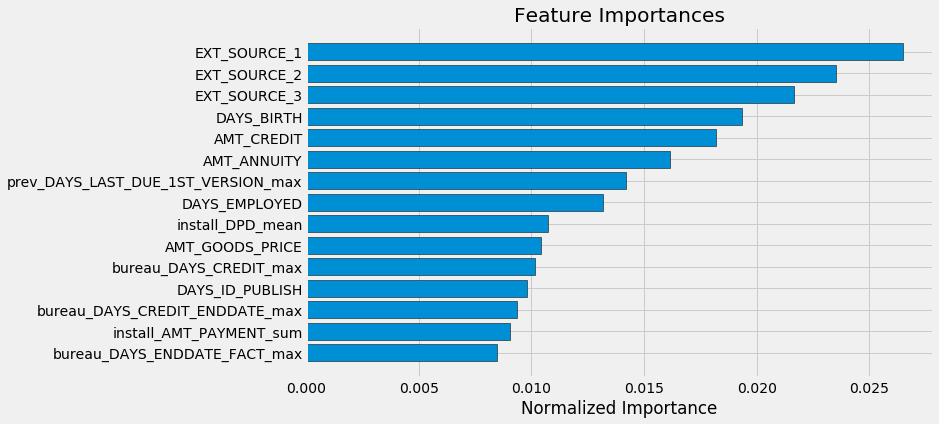

In [6]:
fi_sorted = plot_feature_importances(fi)

In [7]:
app_train, app_test = \
drop_fi_zero_imp(app_train, app_test, fi_sorted)

Before drop zero importance cloumns training shape:  (307511, 993)
Before drop zero importance cloumns testing shape:  (48744, 992)
Drop  233  Column(s)
After drop zero importance cloumns training shape:  (307511, 760)
After drop zero importance cloumns testing shape:  (48744, 759)


In [ ]:
app_train, app_test = \
remove_cor(app_train, app_test, threshold=.9)

In [ ]:
submission, fi, metrics = lgb_model(app_train, app_test)

In [ ]:
metrics

In [10]:
submission.to_csv('./model_performance/all_data_pred.csv', index = False)